# Logistic regression

Today, you are going to be experimenting with logistic regression. As described in the lectures, logistic regression is simply a regression model that is passed through a sigmoid function. This forces the output to be in the range [0, 1], which is why our binary labels must be encoded as {0, 1} and also why we can pretend that this output is a probability.

Below, you will find code for making data, classifiers, and optimizing the parameters. You will also be provided with some plotting code.

In [ ]:
import numpy as np
from sklearn.datasets import make_classification, make_moons, make_blobs  # Toy data

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
# from sklearn.metrics import confusion_matrix

## Data

Let's make some data.

In [ ]:
X, y = make_blobs(n_samples=200, centers=2, cluster_std=.7, n_features=2, random_state=0)
X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1) # Add pseudo input
X[:5], y[:5]

(array([[1.        , 2.59193175, 1.14706863],
        [1.        , 1.7756532 , 1.15670278],
        [1.        , 2.8032241 , 0.5802936 ],
        [1.        , 1.6090616 , 0.61957339],
        [1.        , 2.04921553, 5.33233847]]), array([1, 1, 1, 1, 0]))

In [ ]:
X, y = make_moons(n_samples=200, noise=.1, random_state=0)
X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1) # Add pseudo input
X[:5], y[:5]

(array([[ 1.        ,  0.79235735,  0.50264857],
        [ 1.        ,  1.63158315, -0.4638967 ],
        [ 1.        , -0.06710927,  0.26776706],
        [ 1.        , -1.04412427, -0.18260761],
        [ 1.        ,  1.76704822, -0.19860987]]), array([0, 1, 1, 0, 1]))

We want to easily be able to plot the data. The classifier function should take a point and output an integer label. You can redefine it yourself below.

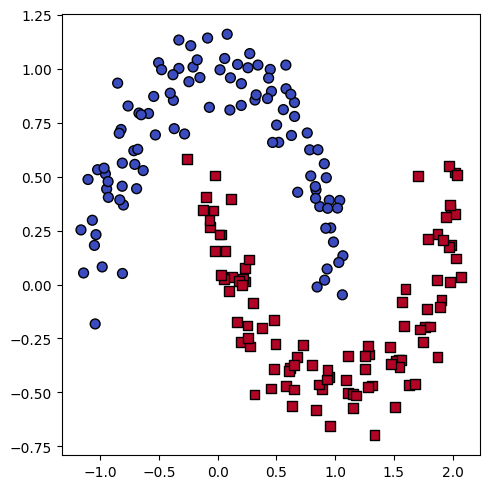

In [ ]:
def plot_classification(X, y, classifier=None):
  plt.figure(figsize=(5, 5), dpi=100)
  markers = ['o', 's', 'd']
  for j, label in enumerate(np.unique(y)):
    if X.shape[1] == 2:
      # No pseudo input
      plt.scatter(X[y==label, 0], X[y==label, 1], c=y[y==label], s=50, marker=markers[j], edgecolor='k', cmap='coolwarm', vmin=y.min(), vmax=y.max())
    else:
      # X includes pseudo inputs
      plt.scatter(X[y==label, 1], X[y==label, 2], c=y[y==label], s=50, marker=markers[j], edgecolor='k', cmap='coolwarm', vmin=y.min(), vmax=y.max())
  if classifier is not None:
    # Create a plotting mesh
    a = plt.axis()          # The mesh will adapt plotted data
    XX, YY = np.meshgrid(np.linspace(a[0], a[1], 20),
                        np.linspace(a[2], a[3], 20))
    mesh_points = [np.vstack(XX.ravel()), np.vstack(YY.ravel())]  # Reshape the x and y coordinates to columns
    mesh_points.insert(0, np.ones(mesh_points[0].shape))  # Add pseudo input
    mesh_points = np.concatenate(mesh_points, axis=1)     # Convert to numpy array
    # Run classification
    Z = np.apply_along_axis(classifier, 1, mesh_points) 
    # Plot, contourf will interpolate the colour between our mesh points
    plt.contourf(XX, YY, Z.reshape(XX.shape), alpha=.5, cmap='coolwarm', zorder=-1)
  plt.tight_layout()
  plt.show()

plot_classification(X, y)

## Modelling

We can now define the constituent functions and make a model.

In [ ]:
def regression(X, theta):
  """Regression function
  Assumes a pseudo input and preforms a dot product between each row of the 
  data matrix and the parameter vector."""
  if X.ndim==1:
    X = np.vstack(X).T
  return X.dot(np.vstack(theta)).ravel()

def sigmoid(z):
  """Sigmoid function
  Runs element wise on the input data."""
  return 1/(1+np.exp(-z))

def model(x, theta):
  """Logistic regression"""
  return sigmoid(regression(x, theta)).ravel()

We can plot the sigmoid to verify that we got it right.

Note that the sigmoid function never becomes flat at the extremes (it does come close though). Why?

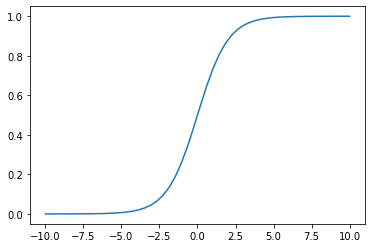

In [ ]:
plt.figure()
x = np.linspace(-10, 10, 50)
plt.plot(x, sigmoid(x))
plt.show()

We can select our initial $\theta$ in any way we like. Here are two alterantives. We now have everything we need to assemble the model and classify.

In [ ]:
theta = np.zeros(3)
# theta = np.random.normal(size=3)

regression(X, theta)[:5], sigmoid(regression(X, theta))[:5], model(X, theta)[:5]

(array([0., 0., 0., 0., 0.]),
 array([0.5, 0.5, 0.5, 0.5, 0.5]),
 array([0.5, 0.5, 0.5, 0.5, 0.5]))

## Choosing parameters
To do optimization, we need some loss functions.

In [ ]:
def squared_loss(y, y_hat):
  """Squared loss
  This is normal used for regression, but also works here."""
  return np.sum((y - y_hat)**2)

def logistic_loss(y, y_hat):
  """Logistic loss
  This is the standard loss function for logistic regression."""
  return np.sum(-y*np.log(y_hat)-(1-y)*np.log(1-y_hat))

We can try the same optimization algorithms as last time.

In [ ]:
def coordinate_descent(function_to_minimize, initial_theta, n_iterations=50, step=.25):
  """Coordinate descent (look at wikipedia for definition)"""
  theta = initial_theta.copy()
  history = [initial_theta.copy()]
  function_values = [function_to_minimize(initial_theta)]
  for iteration in range(n_iterations):
    theta_changed_during_iter = False
    for dim in range(len(initial_theta)):
      for direction in [-1, 1]:
        new_theta = theta.copy()
        new_theta[dim] += direction*step
        while function_to_minimize(new_theta) < function_to_minimize(theta):
          theta = new_theta
          theta_changed_during_iter = True
          history.append(theta)
          function_values.append(function_to_minimize(new_theta))
          new_theta = theta.copy()
          new_theta[dim] += direction*step
    if not theta_changed_during_iter:
      step /= 2
      # break
  return theta, function_values, np.concatenate([np.vstack(h).T for h in history])

def finite_difference_gradient_descent(function_to_minimize, initial_theta, n_iterations=20, gamma=.01):
  """Gradient descent optimization, where the gradient is approximated using
  finite difference. Look at scipy.optimize.approx_fprime to learn more."""
  from scipy.optimize import approx_fprime
  theta = initial_theta.copy()
  history = [initial_theta.copy()]
  function_values = [function_to_minimize(initial_theta)]
  for iteration in range(n_iterations):
    gradient = approx_fprime(theta, function_to_minimize, epsilon=.001)
    theta = theta - gamma*gradient
    history.append(theta)
    function_values.append(function_to_minimize(theta))
  return theta, function_values, np.concatenate([np.vstack(h).T for h in history])

def random_changes(function_to_minimize, initial_theta, n_iterations=200, noise_sd=.1):
  """Adds random noise to the parameter vector in the hope of 
  improving the loss."""
  theta = initial_theta.copy()
  history = [initial_theta.copy()]
  function_values = [function_to_minimize(initial_theta)]
  for iteration in range(n_iterations):
    new_theta = theta + np.random.normal(scale=noise_sd, size=theta.shape)
    if function_to_minimize(new_theta) < function_to_minimize(theta):
      theta = new_theta
    history.append(theta.copy())
    function_values.append(function_to_minimize(theta))
  return theta, function_values, np.concatenate([np.vstack(h).T for h in history])

def scipy_minimize(function_to_minimize, initial_theta):
  """Optimization using external library. Look at the manual of 
  scipy.optimize.minimize for specifics."""
  from scipy.optimize import minimize
  history = [initial_theta.copy()]
  function_values = [function_to_minimize(initial_theta)]
  def store_theta_during_optimization(current_theta):
    history.append(current_theta)
    function_values.append(function_to_minimize(current_theta))
  res = minimize(lambda t: function_to_minimize(t), initial_theta, 
                 callback=store_theta_during_optimization)
  return theta, function_values, np.concatenate([np.vstack(h).T for h in history])

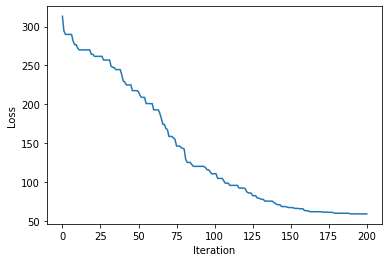

In [ ]:
# theta, loss, history = coordinate_descent(function_to_minimize=lambda theta: logistic_loss(y, model(X, theta)), 
#                                           initial_theta=np.random.normal(size=3),
#                                           n_iterations=200, step=.25)

# theta, loss, history = finite_difference_gradient_descent(function_to_minimize=lambda theta: logistic_loss(y, model(X, theta)), 
#                                                           initial_theta=np.random.normal(size=3), 
#                                                           n_iterations=60, gamma=.01)

theta, loss, history = random_changes(function_to_minimize=lambda theta: logistic_loss(y, model(X, theta)),
                                      initial_theta=np.random.normal(size=3),
                                      n_iterations=200, noise_sd=.1)

# theta, loss, history = scipy_minimize(function_to_minimize=lambda theta: logistic_loss(y, model(X, theta)),
#                                       initial_theta=np.random.normal(size=3))

plt.figure()
plt.plot(loss)
plt.ylabel("Loss")
plt.xlabel("Iteration")
plt.show()

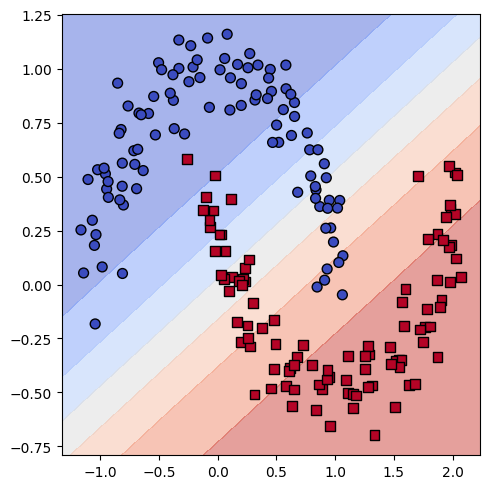

In [ ]:
plot_classification(X, y, lambda x: model(x, theta))

In [ ]:
import ipywidgets

def plot_wrapper(iteration):
  # theta = 
  # print("Intercept: %.1f, Slope: %.1f" % (intercept, slope))
  # interactive_residual_plot(intercept, slope)
  plot_classification(X, y, lambda x: model(x, history[iteration]))
interact_plot = ipywidgets.interact(plot_wrapper,
                                    iteration = ipywidgets.Play(min=0, max=len(history)-1, step=max(1, len(history)//100), value=0));
output = interact_plot.widget.children[-1] # This should prevent flickering
output.layout.height = '500px'
# Note that the play button doesn't always show up in colab. The clickable area is still there though (leftmost gray area).

interactive(children=(Play(value=0, description='iteration', max=200, step=2), Output()), _dom_classes=('widge…

Making predictions is easy from what we have. By pushing the model output through np.round, we get labels in {0, 1}. This makes is possible to calculate the accuracy.

In [ ]:
prediction = np.round(model(X, theta))
correct = np.equal(prediction, y)
print("Accuracy:", 100*np.sum(correct)/len(correct))

Accuracy: 85.0


## More complex data

Logistic regression can be extended to handle multi class classification. This will be discussed in a future lecture. Can you think of an extension to logistic regression that would give a multi class output?

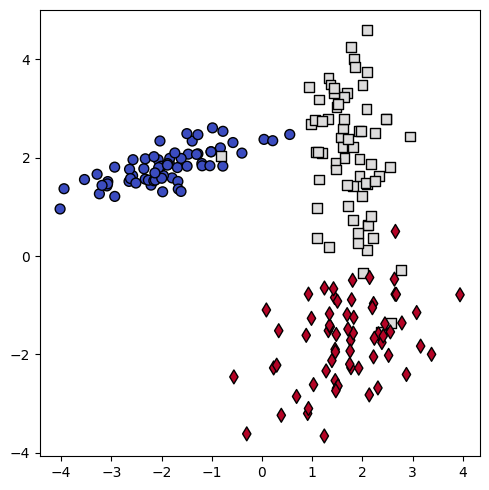

(array([[ 1.        ,  2.00120424,  3.48585849],
        [ 1.        , -1.27565612,  2.07888341],
        [ 1.        ,  2.65445232, -0.77822912],
        [ 1.        ,  0.92692666, -0.77581931],
        [ 1.        , -1.78887301,  1.58891079]]), array([1, 0, 2, 2, 0]))

In [ ]:
X, y = make_classification(n_samples=200, n_features=2, n_informative=2, 
                           n_redundant=0, n_repeated=0, n_classes=3, class_sep=1.8,
                           n_clusters_per_class=1, random_state=0)
X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1) # Add pseudo input

plot_classification(X, y)

X[:5], y[:5]

(array([[1. , 5.1, 3.5, 1.4, 0.2],
        [1. , 4.9, 3. , 1.4, 0.2],
        [1. , 4.7, 3.2, 1.3, 0.2],
        [1. , 4.6, 3.1, 1.5, 0.2],
        [1. , 5. , 3.6, 1.4, 0.2]]), array([0, 0, 0, 0, 0]))

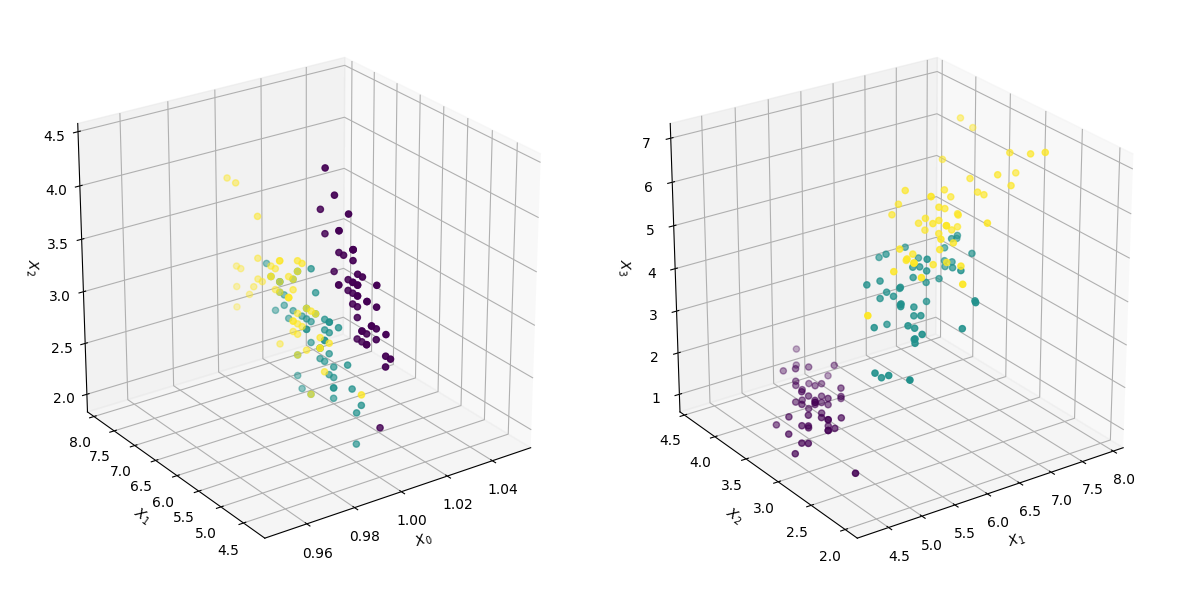

In [ ]:
from sklearn.datasets import load_iris
X = load_iris().data
X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1) # Add pseudo input
y = load_iris().target

fig = plt.figure(figsize=(12, 6), dpi=100)
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y)
ax.set_xlabel("$X_0$")
ax.set_ylabel("$X_1$")
ax.set_zlabel("$X_2$")
ax.view_init(25, -125)
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(X[:, 1], X[:, 2], X[:, 3], c=y)
ax.set_xlabel("$X_1$")
ax.set_ylabel("$X_2$")
ax.set_zlabel("$X_3$")
ax.view_init(25, -125)
fig.tight_layout()
fig.show()

X[:5], y[:5]

We now have 3 classes and, with the Iris data, more data dimensions. Can this be done using binary classification?

There are several ways of dealing with this, more on this in lecture 5. We can try out to simply add two logistic regressions together and, the data willing, we might get a good classification. To do this we have to create a longer $\theta$ and slice it.

In [ ]:
theta = np.random.normal(size=X.shape[1]*2)
theta, theta[:len(theta)//2], theta[len(theta)//2:]

(array([ 0.57922046, -1.51232223, -0.37579732, -1.62716944,  0.44285986,
        -0.22288381]),
 array([ 0.57922046, -1.51232223, -0.37579732]),
 array([-1.62716944,  0.44285986, -0.22288381]))

Investigate this model. Are there other ways of setting this up? Is this easilly optimized? Does logistic loss work here?

In [ ]:
multilabel_model = lambda X, theta: sigmoid(regression(X, theta[:len(theta)//2])) + sigmoid(regression(X, theta[len(theta)//2:]))
multilabel_model(X, theta)

array([0.20259299, 0.91470551, 0.47228333, 0.63070069, 0.99505422,
       1.02379922, 1.02530049, 0.52352678, 0.30514971, 0.98956584,
       0.63052353, 0.57656754, 0.76353043, 0.36012869, 0.8608134 ,
       1.02894357, 0.25007131, 0.94351562, 0.22794986, 1.19455834,
       0.51986687, 0.52386862, 0.60814038, 0.81452733, 1.02624479,
       1.00644658, 0.35182216, 0.51284863, 0.52493236, 1.01277956,
       0.80889806, 0.39288006, 0.6399753 , 0.2431945 , 0.98866943,
       1.01368477, 0.35744359, 1.02166221, 0.99951035, 0.35827096,
       0.29047811, 0.55453035, 0.6280576 , 1.02422513, 0.22597538,
       0.69132028, 0.16467711, 0.23921082, 0.69480675, 1.00350552,
       0.52684179, 0.913886  , 0.27169817, 0.21838936, 0.28454107,
       1.01807025, 1.02346192, 0.61992612, 0.25748661, 0.9844874 ,
       0.26062678, 0.52595331, 1.02580836, 0.89821848, 1.01561007,
       0.48914112, 0.98641919, 0.19412954, 0.30439431, 0.97926939,
       0.4449681 , 0.60040302, 0.52540796, 0.73479604, 0.27238

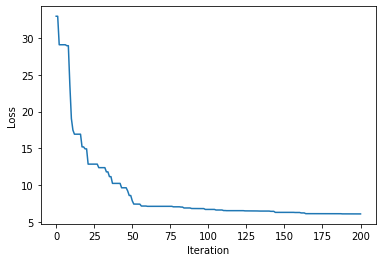

In [ ]:
theta, loss = random_changes(function_to_minimize=lambda theta: squared_loss(y, multilabel_model(X, theta)),
                             initial_theta=np.random.normal(size=X.shape[1]*2),
                             n_iterations=200, noise_sd=.1)

plt.figure()
plt.plot(loss)
plt.ylabel("Loss")
plt.xlabel("Iteration")
plt.show()

In [ ]:
prediction = np.round(multilabel_model(X, theta))
correct = np.equal(prediction, y)
print("Accuracy:", 100*np.sum(correct)/len(correct))

Accuracy: 96.5


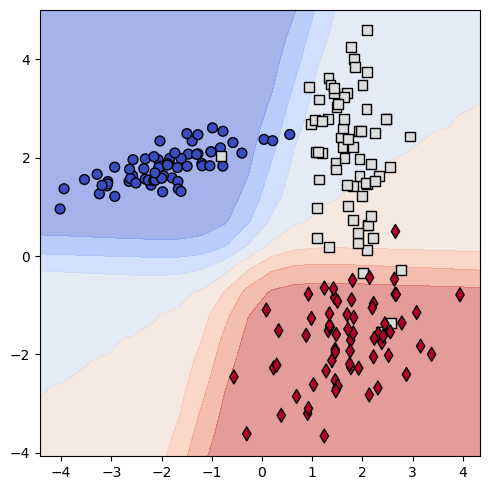

In [ ]:
plot_classification(X, y, lambda x: multilabel_model(x, theta)) # This will not work with the iris data